In [ ]:
pip install plip

In [ ]:
pip install matplotlib

In [ ]:
pip install biotite

In [1]:
import logging

logging.getLogger("numexpr").setLevel(logging.ERROR)

from bravado.client import SwaggerClient
from IPython.display import display, Markdown
import pandas as pd
import nglview as nv
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

# import opencadd

# pd.set_option("display.max_columns", 50)

In [2]:
import opencadd

In [3]:
from pathlib import Path
import requests

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import biotite.sequence.align as align

In [1]:
#KLIFS API DATA EXTRACTION

In [4]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [5]:
KLIFS_API_DEFINITIONS = "https://klifs.net/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={"validate_responses": False})

In [6]:
kinase_groups = KLIFS_CLIENT.Information.get_kinase_groups().response().result
display(Markdown("All kinase groups are returned as a list of strings:"))
print(kinase_groups)

All kinase groups are returned as a list of strings:

['AGC', 'CAMK', 'CK1', 'CMGC', 'Other', 'STE', 'TK', 'TKL']


In [7]:
species = "Human"
kinase_group = "AGC"

In [ ]:
kinases = (
    KLIFS_CLIENT.Information.get_kinase_names(kinase_group=kinase_group, species=species)
    .response()
    .result
)
display(
    Markdown(
        f"Kinases in the human group {kinase_group} as a list of objects "
        f"that contain kinase-specific information:"
    )
)
kinases

In [9]:
len(kinases)

64

In [ ]:
kinase_klifs_id = []
x=0
for kinase in kinases:
    kinase_klifs_id.append(kinase.kinase_ID)
    display(Markdown(f"Kinase KLIFS ID for {kinase.name}: {kinase_klifs_id[x]}"))
    x=x+1
# NBVAL_CHECK_OUTPUT

In [11]:
len(kinase_klifs_id)

64

In [12]:
def get_structures(x):
    structures = (
        KLIFS_CLIENT.Structures.get_structures_list(kinase_ID=[x]).response().result)
    # If structures do not contain ligands, the ligand field is set to 0
    # structure = next(structure for structure in structures if structure.ligand != 0)
    return structures

In [13]:
structures=[]
for x in kinase_klifs_id :
    try:
        structures.append(get_structures(x))  
    except:
        pass

In [14]:
structures[1][1]

structureDetails(DFG='in', Grich_angle=58.0868, Grich_distance=17.872, Grich_rotation=52.2938, aC_helix='in', allosteric_ligand=0, alt='A', back=True, bp_III=False, bp_II_A_in=False, bp_II_B=False, bp_II_B_in=False, bp_II_in=False, bp_II_out=False, bp_IV=False, bp_I_A=False, bp_I_B=True, bp_V=False, chain='B', fp_I=False, fp_II=False, front=True, gate=True, kinase='AKT2', kinase_ID=2, ligand='G98', missing_atoms=6, missing_residues=0, pdb='3e8d', pocket='KLLGKGTFGKVILYAMKILHTVTESRVLQNTRPFLTALKYACFVMEYANGGELFFHLSRYLHSRDVVYRDIKLENLMLITDFGLC', quality_score=9.4, resolution=2.7, rmsd1=0.777, rmsd2=2.086, species='Human', structure_ID=1925)

In [15]:
structure_master=[]
valid_ids=[]

for structure in structures :
    for x in structure :
        if x.ligand != 0 and x.DFG == 'in' and x.resolution <= 3 and x.quality_score >= 6:
            structure_master.append(x)
            valid_ids.append(x.structure_ID)
len(structure_master)      

441

In [26]:
def get_interaction_fingerprints(x):
    structure_klifs_id = x
    interaction_fingerprints = (KLIFS_CLIENT.Interactions.get_interactions_get_IFP(structure_ID=[structure_klifs_id]).response().result)
    return interaction_fingerprints


In [27]:
ifps_list=[]
for x in valid_ids:
    try:
        ifps_list.append(get_interaction_fingerprints(x))
        #valid_ids[x]
    except:
        pass

In [28]:
len(ifps_list)

544

In [ ]:
structureDetails={'DFG':'in', 'Grich_angle':48.1597, 'Grich_distance':14.8202, 'Grich_rotation':43.046, 'aC_helix':'out', 'allosteric_ligand':0, 'alt':'A', 'back':True, 'bp_III':False, 'bp_II_A_in':True, 'bp_II_B':False, 'bp_II_B_in':False, 'bp_II_in':True, 'bp_II_out':False, 'bp_IV':False, 'bp_I_A':True, 'bp_I_B':True, 'bp_V':False, 'chain':'A', 'fp_I':False, 'fp_II':False, 'front':True, 'gate':True, 'kinase':'EGFR', 'kinase_ID':406, 'ligand':'W19', 'missing_atoms':0, 'missing_residues':0, 'pdb':'3w33', 'pocket':'KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQLMPFGCLLDYVREYLEDRRLVHRDLAARNVLVITDFGLA', 'quality_score':8.0, 'resolution':1.7, 'rmsd1':0.814, 'rmsd2':2.153, 'species':'Human', 'structure_ID':782}
columns_list=structureDetails.keys()
columns_list

In [30]:
df = pd.DataFrame(columns=columns_list)

In [88]:
df['DFG'] = [structure.DFG for structure in structure_master]
for column in columns_list :
    # print(column)
    df[column] = [structure[column] for structure in structure_master]
df.head()

,DFG,Grich_angle,Grich_distance,Grich_rotation,aC_helix,allosteric_ligand,alt,back,bp_III,bp_II_A_in,...,missing_atoms,missing_residues,pdb,pocket,quality_score,resolution,rmsd1,rmsd2,species,structure_ID
0,in,59.5972,18.0522,57.1354,in,0,A,False,False,False,...,0,0,3mvh,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,8.0,2.01,0.778,2.093,Human,2538
1,in,55.3905,16.7899,67.8693,in,0,,False,False,False,...,0,0,4ekk,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,8.0,2.80,0.779,2.092,Human,2539
2,in,55.7058,17.2603,65.7051,in,0,,False,False,False,...,0,0,4ekl,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,8.0,2.00,0.782,2.102,Human,2540
3,in,57.0960,17.1370,63.4985,in,0,,False,False,False,...,0,0,4ekk,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,8.0,2.80,0.779,2.090,Human,2541
4,in,58.4164,17.8309,58.9605,in,0,A,False,False,False,...,0,0,4gv1,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,8.0,1.49,0.778,2.095,Human,2543


In [32]:
ids_with_ifps_list=[]
for x in range(0,len(ifps_list)):
    ids_with_ifps_list.append(ifps_list[x][0]['structure_ID'])

In [33]:
len(ids_with_ifps_list)

544

In [34]:
ifps=[]
ifps = [ifps_list[x][0]['IFP'] for x in range(len(ids_with_ifps_list))]
#ifps

In [100]:
# df = df[df['kinase_ID'].isin(ids_with_ifps_list)]
df['ifps'] = ifps
df

,DFG,Grich_angle,Grich_distance,Grich_rotation,aC_helix,allosteric_ligand,alt,back,bp_III,bp_II_A_in,...,missing_residues,pdb,pocket,quality_score,resolution,rmsd1,rmsd2,species,structure_ID,ifps
0,in,59.5972,18.0522,57.1354,in,0,A,False,False,False,...,0,3mvh,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,8.0,2.01,0.778,2.093,Human,2538,0000000000000010000001000000100000010000000000...
1,in,55.3905,16.7899,67.8693,in,0,,False,False,False,...,0,4ekk,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,8.0,2.80,0.779,2.092,Human,2539,0000000000000010000001000000000000000000000000...
2,in,55.7058,17.2603,65.7051,in,0,,False,False,False,...,0,4ekl,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,8.0,2.00,0.782,2.102,Human,2540,0000000000000010000001000000100000010000000000...
3,in,57.0960,17.1370,63.4985,in,0,,False,False,False,...,0,4ekk,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,8.0,2.80,0.779,2.090,Human,2541,0000000000000010000001000000000000000000000000...
4,in,58.4164,17.8309,58.9605,in,0,A,False,False,False,...,0,4gv1,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,8.0,1.49,0.778,2.095,Human,2543,0000000000000010000001000000100000010000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,in,65.1528,19.0582,69.5888,in,0,A,False,False,False,...,0,4fr4,RAIGKGSFGKVCIYAMKYMNVFKELQIMQGLEPFLVNLWYSFMVVD...,9.7,2.29,0.782,2.089,Human,4693,0000000000000010000001000000000000000000000000...
540,in,65.3580,19.1003,70.4030,in,0,B,False,False,False,...,0,4fr4,RAIGKGSFGKVCIYAMKYMNVFKELQIMQGLEPFLVNLWYSFMVVD...,8.0,2.29,0.781,2.089,Human,4694,0000000000000010000001000000000000000000000000...
541,in,65.2708,19.0794,69.9568,in,0,B,False,False,False,...,0,4fr4,RAIGKGSFGKVCIYAMKYMNVFKELQIMQGLEPFLVNLWYSFMVVD...,9.7,2.29,0.782,2.089,Human,4695,0000000000000010000001000000000000000000000000...
542,out-like,49.0252,15.5559,65.4603,out,0,,False,False,False,...,0,6bxi,KVIGRGAFGEVRLYAMKILHIRAERDILVEADLWVVKMFYSYLIME...,9.6,2.20,0.816,2.177,Human,10325,0000000000000010000001000000000000000000000000...


In [1]:
#KINASE VISUALISATION USING ViewNGL

In [ ]:
from opencadd.structure.pocket import PocketKlifs, PocketViewer

# Get structure and pocket
pocket = PocketKlifs.from_structure_klifs_id(1)

# Show pocket
viewer = PocketViewer()
viewer.add_pocket(pocket, show_pocket_center=False)
# viewer.viewer.add_ball_and_stick()
viewer.viewer

In [104]:
viewer.viewer.render_image(trim=True, factor=2);

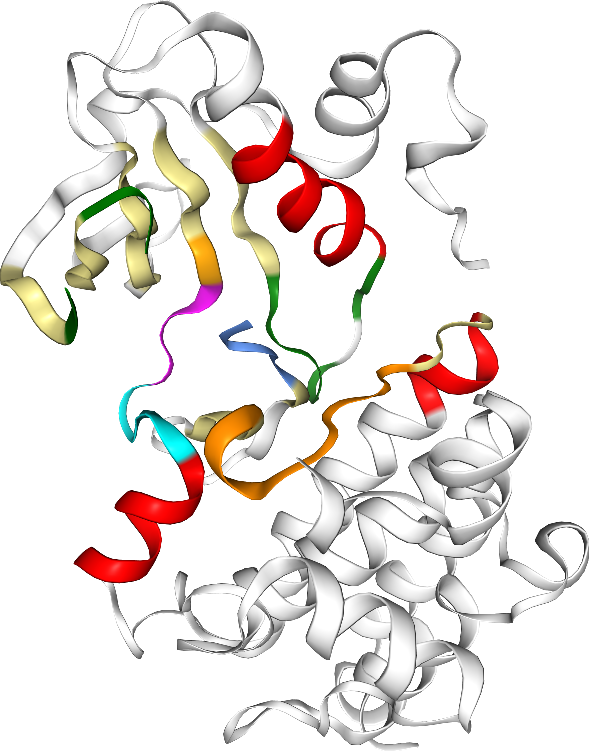

In [105]:
viewer.viewer._display_image()

In [2]:
#KINASE POCKET STRUCTURE ANALYSIS

In [67]:
kinase_names=[]
for x in df['kinase']:
    kinase_names.append(x)
# kinase_names
df_pocket_sequence=pd.DataFrame(columns = kinase_names)
df_pocket_sequence['index']=list(range(0,85))
# df_pocket_sequence

In [ ]:
pockets_list = list(df.pocket.values)
(pockets_list)

In [68]:
i = 0
for col in kinase_names:
    for y in range(0, 85):
        df_pocket_sequence.loc[y, col] = pockets_list[i][y]
    i=i+1
df_pocket_sequence = df_pocket_sequence.copy()


In [69]:
df_pocket_sequence

,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,...,YANK1,YANK1,YANK1,YANK1,YANK1,YANK1,YANK1,NDR1,NDR1,index
0,K,K,K,K,K,K,K,K,K,K,...,R,R,R,R,R,R,R,K,K,0
1,L,L,L,L,L,L,L,L,L,L,...,A,A,A,A,A,A,A,V,V,1
2,L,L,L,L,L,L,L,L,L,L,...,I,I,I,I,I,I,I,I,I,2
3,G,G,G,G,G,G,G,G,G,G,...,G,G,G,G,G,G,G,G,G,3
4,K,K,K,K,K,K,K,K,K,K,...,K,K,K,K,K,K,K,R,R,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,D,D,D,D,D,D,D,D,D,D,...,D,D,D,D,D,D,D,D,D,80
81,F,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,81
82,G,G,G,G,G,G,G,G,G,G,...,N,N,N,N,N,N,N,G,G,82
83,L,L,L,L,L,L,L,L,L,L,...,I,I,I,I,I,I,I,L,L,83


In [ ]:
df_pocket_sequence=df_pocket_sequence.drop('index', axis=1)
df_pocket_sequence

In [3]:
#POCKET SEQUENCE ANALYSIS

In [71]:
def find_most_frequent(row):
    mode_result = row.mode()
    most_frequent_letter = mode_result.iloc[0]
    frequency = row.value_counts().loc[most_frequent_letter]
    return pd.Series([most_frequent_letter, frequency], index=['Most_Frequent_Letter', 'Frequency'])

# Apply the function to each row
most_frequent_info = df_pocket_sequence.apply(find_most_frequent, axis=1)

# Concatenate the new DataFrame with the existing DataFrame
df_pocket_sequence = pd.concat([df_pocket_sequence, most_frequent_info], axis=1)

# Print the updated DataFrame
df_pocket_sequence


,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,...,YANK1,YANK1,YANK1,YANK1,YANK1,YANK1,NDR1,NDR1,Most_Frequent_Letter,Frequency
0,K,K,K,K,K,K,K,K,K,K,...,R,R,R,R,R,R,K,K,K,414
1,L,L,L,L,L,L,L,L,L,L,...,A,A,A,A,A,A,V,V,V,233
2,L,L,L,L,L,L,L,L,L,L,...,I,I,I,I,I,I,I,I,L,342
3,G,G,G,G,G,G,G,G,G,G,...,G,G,G,G,G,G,G,G,G,539
4,K,K,K,K,K,K,K,K,K,K,...,K,K,K,K,K,K,R,R,R,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,D,D,D,D,D,D,D,D,D,D,...,D,D,D,D,D,D,D,D,D,544
81,F,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,479
82,G,G,G,G,G,G,G,G,G,G,...,N,N,N,N,N,N,G,G,G,532
83,L,L,L,L,L,L,L,L,L,L,...,I,I,I,I,I,I,L,L,T,236


In [4]:
#POCKET REGION DEFINITIONS 

In [ ]:
kinase_pocket_regions = {
    'hinge': list(range(45, 48)),
    'G-rich loop': list(range(3, 9)),
    'alpha C loop': list(range(19, 30)),
    'linker': list(range(48, 52)),
    'activation loop': list(range(83, 85)),
    'DFG motif': list(range(79, 83)),
    'gatekeeper': [44],  
    'catalytic loop': list(range(67, 75)),
    'alpha D loop': list(range(52, 59)),  
    'alpha E loop': list(range(59, 64))  
}
for region, positions in kinase_pocket_regions.items():
    print(region, positions)

In [ ]:
df_pocket_sequence['index'] = list(range(0,85))
def map_position_to_region(position):
    for region, positions in kinase_pocket_regions.items():
        if position in positions:
            return region
    return None  # Return None if the position doesn't match any region

# Apply the function to the 'Most_Frequent_Letter' column and create a new column
df_pocket_sequence['Pocket_Region'] = df_pocket_sequence['index'].apply(map_position_to_region)

# Print the updated DataFrame
df_pocket_sequence.head()

In [82]:
df_pocket_sequence['Most_Frequent_Letter'] = df_pocket_sequence['Most_Frequent_Letter'].replace('_', 'O')

In [83]:
df_pocket_sequence.head()

,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,AKT1,...,YANK1,YANK1,YANK1,YANK1,NDR1,NDR1,Most_Frequent_Letter,Frequency,index,Pocket_Region
0,K,K,K,K,K,K,K,K,K,K,...,R,R,R,R,K,K,K,414,0,None
1,L,L,L,L,L,L,L,L,L,L,...,A,A,A,A,V,V,V,233,1,None
2,L,L,L,L,L,L,L,L,L,L,...,I,I,I,I,I,I,L,342,2,None
3,G,G,G,G,G,G,G,G,G,G,...,G,G,G,G,G,G,G,539,3,G-rich loop
4,K,K,K,K,K,K,K,K,K,K,...,K,K,K,K,R,R,R,191,4,G-rich loop
5,G,G,G,G,G,G,G,G,G,G,...,G,G,G,G,G,G,G,544,5,G-rich loop
6,T,T,T,T,T,T,T,T,T,T,...,S,S,S,S,A,A,S,262,6,G-rich loop
7,F,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,493,7,G-rich loop
8,G,G,G,G,G,G,G,G,G,G,...,G,G,G,G,G,G,G,402,8,G-rich loop
9,K,K,K,K,K,K,K,K,K,K,...,K,K,K,K,E,E,E,175,9,None


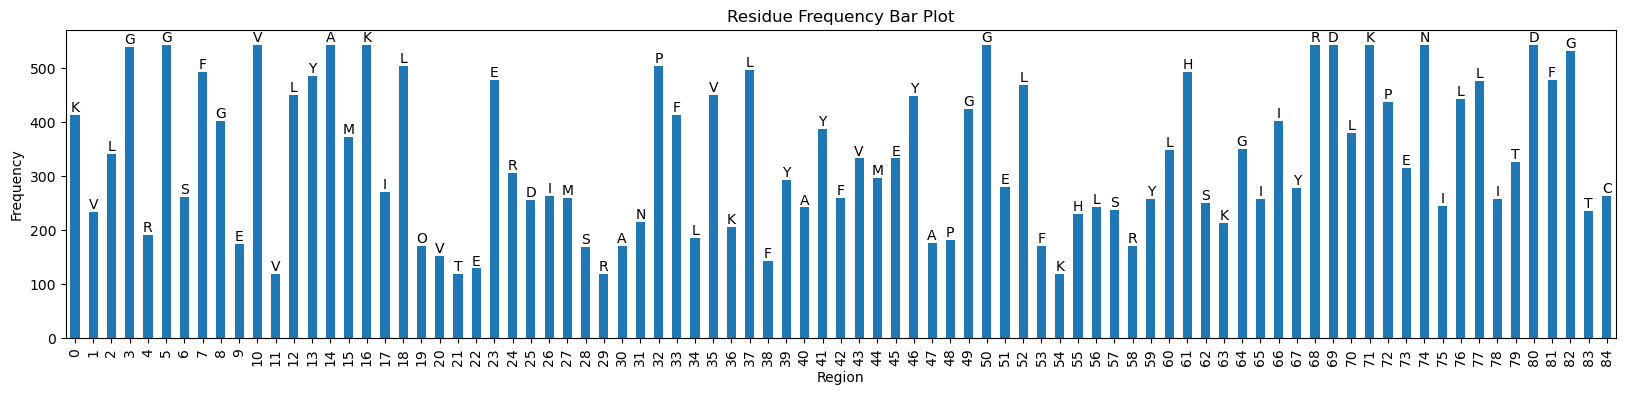

In [84]:

import matplotlib.pyplot as plt
# Plotting a bar plot
ax = df_pocket_sequence.plot(x='index', y='Frequency', kind='bar', figsize=(20,4),legend=False)
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.title('Residue Frequency Bar Plot')

# Adding text labels to each bar
for i, value in enumerate(df_pocket_sequence['Frequency']):
    ax.text(i, value + 0.5, str(df_pocket_sequence['Most_Frequent_Letter'][i]), ha='center', va='bottom')


plt.show()


In [5]:
#KINASE INTERACTIONS ANALYSIS

In [ ]:
df_ifps=pd.DataFrame(columns=kinase_names)
df_ifps['index']=list(range(0,85))
df_ifps

In [ ]:
df_ifps.head(20)

In [ ]:
#EXTRACTING IF

In [ ]:
y=0
z=0
for col in df_ifps:
    try :
        df_ifps[col]=[list(df['ifps'][y][x:x+7]) for x in range(0, 85)]
    except :
        pass 
        z=z+1
    y=y+1
print(y)
df_ifps

In [ ]:
df_ifps=df_ifps.astype('int32', errors='ignore')
df_ifps

In [ ]:
df_ifps_ = df_ifps.dropna(axis=1)
df_ifps_.head()

In [147]:
len(df_ifps.columns)

545

In [148]:
def add_function(df, i, k):
    result = 0
    for j in range(0, 21):
        result += int(df.iloc[i, j][k])
    return result

In [149]:
sum_columns = []

for i in range (0,85):
    xyz = []
    for k in range (0,7):
        # int(df_ifps.iloc[i,j][k])
        xyz.append(add_function(df_ifps_,i,k))
    sum_columns.append(xyz)

In [ ]:
df_ifps_["sum_columns"] = sum_columns
df_ifps=df_ifps_
df_ifps

In [ ]:
interaction_list=[]
interaction_frequency=[]
y=0
for x in df_ifps['sum_columns']:
    max_value=max(x)
    if max_value>0 :
        interaction_list.append(x.index(max_value))
        interaction_frequency.append(max_value)
    else : 
        interaction_list.append('-')
        interaction_frequency.append('0')
interaction_frequency
    

In [ ]:
interaction_list_names=[]
dict_={'-':'-',0:'Apolar contact', 1:'Aromatic face-to-face', 2:'Aromatic edge-to-face', 3:'Hydrogen bond donor (protein)', 4:'Hydrogen bond acceptor (protein)',5:'Protein cation - ligand anion', 6:'Protein anion - ligand cation'}
for x in interaction_list:
    interaction_list_names.append(dict_[x])
interaction_list_names
    

In [ ]:
df_ifps['interaction type']=interaction_list_names
df_ifps['interaction frequency']=interaction_frequency

In [88]:
df_ifps.head()

,AKT1,DMPK1,BARK1,GPRK4,GPRK5,PDK1,PKACa,PKCa,PKCb,PKCh,...,RSK3,RSK2,RSK4,SGK1,YANK1,NDR1,index,sum_columns,interaction type,interaction frequency
0,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0,"[2, 0, 0, 0, 0, 0, 0]",Apolar contact,2
1,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",1,"[0, 0, 0, 0, 0, 0, 0]",-,0
2,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",2,"[0, 0, 0, 0, 0, 0, 0]",-,0
3,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",3,"[0, 0, 0, 0, 0, 0, 0]",-,0
4,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",4,"[0, 0, 0, 0, 0, 0, 0]",-,0


In [80]:
df_ifps['interaction frequency']=df_ifps['interaction frequency'].astype('int64')

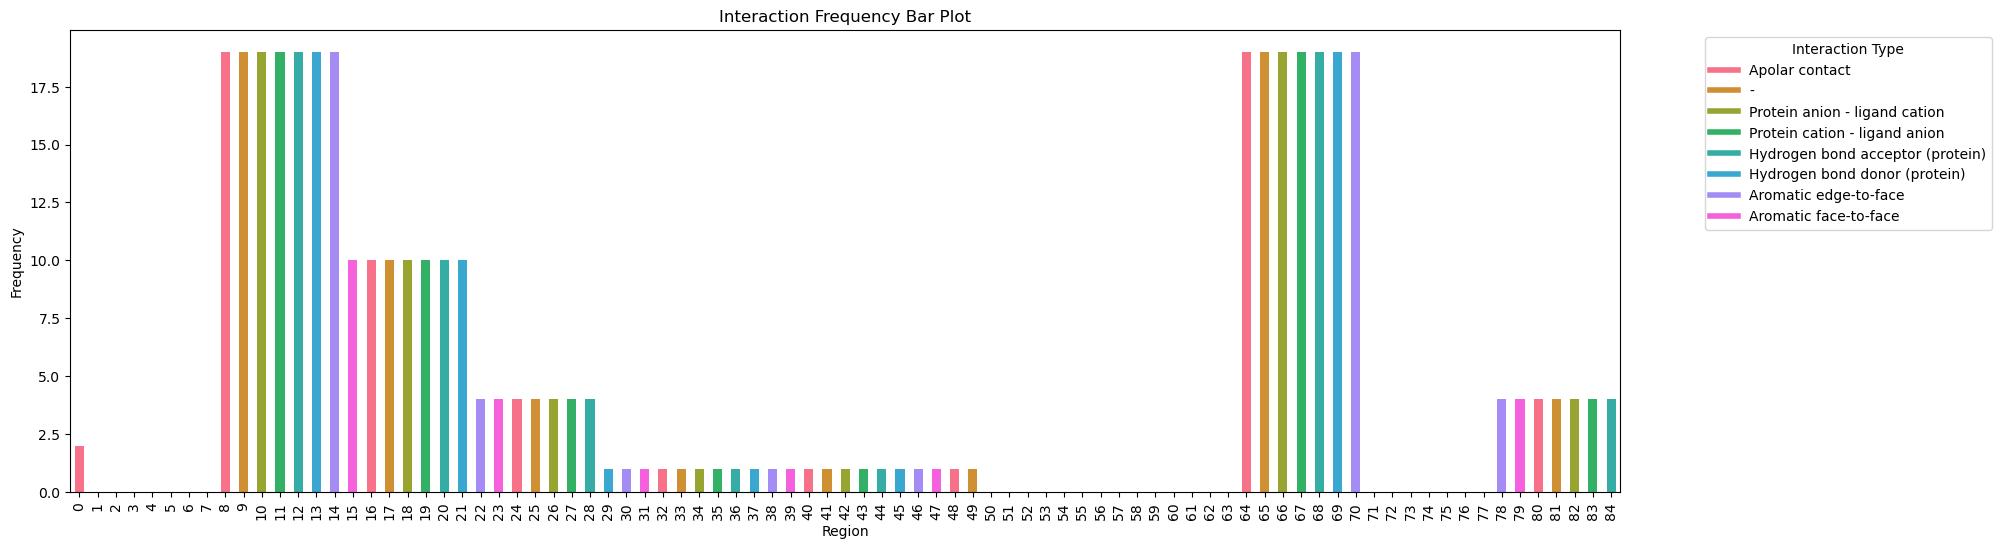

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_ifps is your DataFrame

# Set a color palette for each unique 'interaction type'
interaction_type_palette = sns.color_palette("husl", n_colors=len(df_ifps['interaction type'].unique()))

# Plotting a bar plot
ax = df_ifps.plot(x='index', y='interaction frequency', kind='bar', figsize=(20, 6), legend=False, color=interaction_type_palette)
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.title('Interaction Frequency Bar Plot')

# Create a legend with unique colors for each 'interaction type'
legend_labels = df_ifps['interaction type'].unique()
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in interaction_type_palette]
plt.legend(legend_handles, legend_labels, title='Interaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding text labels to each bar
for i, value in enumerate(df_ifps['interaction frequency']):
    ax.text(i, value + 0.5, '', ha='center', va='bottom')  # Remove individual labels for better clarity

plt.show()
